#1

In [260]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


# Parameters
L = 2.0             # Length of the beam [m]
EI = 2e6            # Flexural rigidity [Nm^2]
Q = 1e3 # Uniform load [N/m]
P = 1e3         # Point load [N]
a = L / 2            # Load applied at midspan
hinge_loc = L / 2.

colloc_width = L / 4.
colloc_density = 20

dl = 0.005 * L
dl_norm = tf.cast(dl / L, dtype = tf.float32)

act = 'relu'
Noise = False
noise_scale = 1e-1
USE_COLLOC = False

Case = 'Cantilever'

In [261]:
x_full = np.linspace(0, L, 200)
x_full_norm = x_full/ L

def w_udl(x, Q, constants):
    
    A, B, C, D = constants
    k = Q / EI
    
    w = tf.cast(k / 24 * x**4 +
                A / 6 * x**3 + 
                B / 2 * x**2 + 
                C * x + 
                D, dtype = tf.float32)

    return w

def w_point_load(x, P, a, constants, smooth = True):
    
    A, B, C, D = constants
    k = P / EI
    
    if smooth:
        H = tf.sigmoid(100 * (x - a))
    else:
        H = tf.where(x < a, 0.0, 1.0)
        
    w = tf.cast(A / 6 * x**3 + 
                B / 2 * x**2 + 
                C * x + 
                D + 
                k / 6 * (x - a)**3 * H, dtype = tf.float32)
    return w

def get_constants(L, P, Q, a):
    
    kp = P / EI
    kq = Q / EI
    
    cantilever_constants_udl = [-L * kq, (L**2 * kq) / 2, 0, 0]
    cantilever_constants_pl = [-kp, kp * a, 0, 0]

    simply_supported_constants_udl = [-(L * kq)/ 2, 0, (L**3 * kq) / 24, 0]
    simply_supported_constants_pl = [-kp * (L - a) / L, 0, kp * a * (L - a) * (2 * L - a) / (6 * L), 0]

    clamped_constants_udl = [-(L * kq) / 2, (L**2 * kq) / 12, 0, 0]
    clamped_constants_pl = [-kp * (L - a)**2 * (L + 2 * a) / L**3, kp * a * (L - a)**2 / L**2, 0, 0]

    if Case == 'Cantilever':
        constants_udl = cantilever_constants_udl
        constants_pl = cantilever_constants_pl
    elif Case == 'SS':
        constants_udl = simply_supported_constants_udl
        constants_pl = simply_supported_constants_pl
    elif Case == 'Clamped':
        constants_udl = clamped_constants_udl
        constants_pl = clamped_constants_pl
    
    return constants_udl, constants_pl

constants_udl, constants_pl = get_constants(L, P, Q, a)

def gaussian_prop(x, x_p, P, sigma=0.1):
     
     A = P / (sigma * tf.sqrt(2.0*tf.constant(np.pi, dtype=tf.float32)))
     return  A * tf.exp(-0.5 * ((x - x_p) / sigma) ** 2)

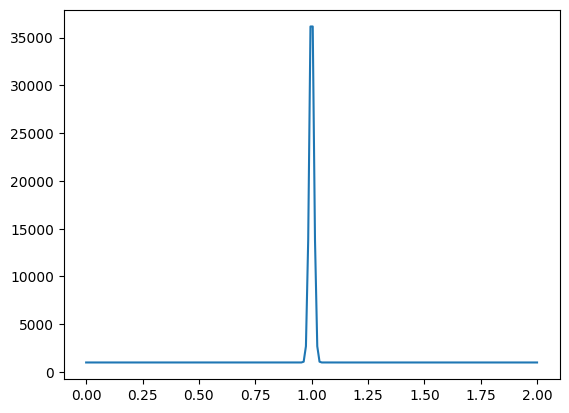

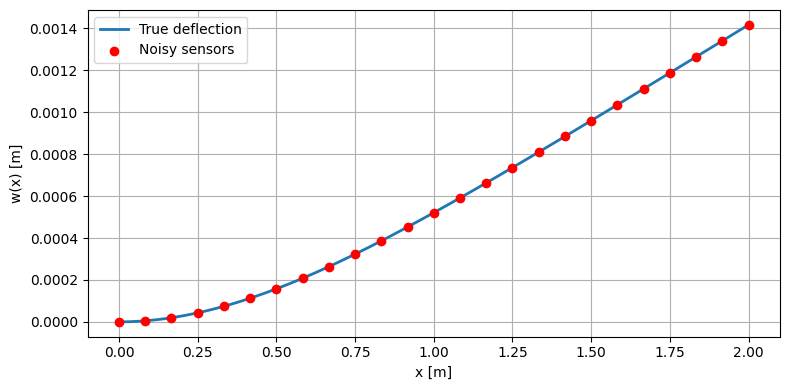

In [262]:
x_full = np.linspace(0, L, 200)

w_true = w_udl(x_full, Q, constants_udl) + w_point_load(x_full, P, a, constants_pl, smooth = False)
#w_true = w(x_full, L, Q)

x_sensors = np.linspace(0, L, 25)
w_sensors_clean = w_udl(x_sensors, Q, constants_udl) + w_point_load(x_sensors, P, a, constants_pl, smooth = False)
#w_sensors_clean = w(x_sensors, L, Q)
w_sensors = w_sensors_clean

x_colloc_phys = tf.concat((tf.linspace(0.0, 0.75, 10),
                      tf.linspace(0.75, 1.25, 80),
                      tf.linspace(1.25, 2.0, 10)), 0)
x_colloc_phys = tf.reshape(x_colloc_phys, (-1 ,1))
x_colloc = x_colloc_phys / L

q_true = Q * tf.ones([200,1]) + gaussian_prop(tf.convert_to_tensor(x_full.reshape(-1,1), dtype=tf.float32), a, P, sigma=0.01)
plt.plot(x_full, q_true)
plt.show()
if Noise:
  np.random.seed(41)
  noise_std = noise_scale * np.max(w_sensors_clean)
  noise = np.random.normal(0, noise_std, size=w_sensors_clean.shape)
  w_sensors += noise

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_full, w_true, label="True deflection", linewidth=2)
plt.scatter(x_sensors, w_sensors, color='red', label="Noisy sensors", zorder=3)
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#2

In [263]:
x_sensors_norm = (x_sensors / L).reshape(-1, 1)
w_max = max(w_sensors_clean)  # still use clean max for scaling
w_sensors_norm = tf.reshape(w_sensors / w_max, (-1, 1))

x_tf = tf.convert_to_tensor(x_full_norm, dtype=tf.float32)
x_tf = tf.reshape(x_tf, (-1, 1))
x_sensors_tf = tf.convert_to_tensor(x_sensors_norm, dtype=tf.float32)
w_sensors_tf = tf.convert_to_tensor(w_sensors_norm, dtype=tf.float32)

q_hat_norm = tf.Variable(0.0, dtype=tf.float32)
q_pl_norm = tf.Variable(0.0, dtype=tf.float32)
pl_loc = tf.Variable(0.0, dtype=tf.float32, trainable=False)

In [264]:
model = keras.models.Sequential([
        keras.layers.Input(shape=(1,)),
        keras.layers.Dense(64, activation = act, dtype = tf.float32),
        keras.layers.Dense(64, activation = act, dtype = tf.float32),
        keras.layers.Dense(1,)
    ])

optimizer = keras.optimizers.Adam(learning_rate = 5e-2)
optimizer_loc = keras.optimizers.Adam(learning_rate=5e-2)

In [265]:
def cumtrapz(x, f):
    dx = x[1:] - x[:-1]
    s = tf.concat([
        tf.cumsum(0.5 * (f[1:] + f[:-1]) * dx),
        tf.zeros_like(f[:1])
    ], axis=0)
    return s

def numerical_integration(x_ext, d4w_phys):
    
    x_ext_phys = x_ext * L
    d4w_phys /= EI
    
    d3w_phys = cumtrapz(x_ext_phys, d4w_phys)
    d2w_phys = cumtrapz(x_ext_phys, d3w_phys)
    dw_phys = cumtrapz(x_ext_phys, d2w_phys)
    w_phys = cumtrapz(x_ext_phys, dw_phys)
    return d3w_phys, d2w_phys, dw_phys, w_phys

x_ext = tf.concat((x_tf, 1 + x_tf[1:5]), 0)

In [266]:
beta = tf.constant(0.9, dtype=tf.float32)  # Smoothing factor

w_data = tf.Variable(1.0, dtype=tf.float32)
w_phys = tf.Variable(0.5, dtype=tf.float32)
w_bc = tf.Variable(1.0, dtype=tf.float32)

w_filter = tf.Variable(0.1, dtype=tf.float32)
w_spikes = tf.Variable(0.1, dtype=tf.float32)

w_all = tf.Variable(1.0, dtype=tf.float32)



In [267]:
def get_q_hat_phys(x_colloc_phys):
    return tf.ones_like(x_colloc_phys) * q_hat_norm * Q + gaussian_prop(x_colloc_phys, a, P * q_pl_norm)

In [268]:
@tf.function
def train_step():
    with tf.GradientTape(persistent=True) as tape:
        
        q_pred_norm = model(x_ext)
        q_pred = Q * q_pred_norm
        d3w, d2w, dw, w_pred = numerical_integration(x_ext, q_pred)
        
        d3w, d2w, dw, w_pred, q_pred = d3w[:-4], d2w[:-4], dw[:-4], w_pred[:-4], q_pred[:-4]
        
        data_loss = tf.reduce_mean(tf.square((w_pred - w_true) / w_max))
        bc_loss = tf.reduce_mean(w_pred[0]**2 + dw[0]**2 + d2w[-1]**2 + d3w[-1]**2)
        
        q_hat_phys = get_q_hat_phys(x_tf)
        physics_residual = q_pred - q_hat_phys
        physics_loss = tf.reduce_mean(tf.square(physics_residual))
        
        differentiable_loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss

    variables = model.trainable_variables + [q_hat_norm, q_pl_norm]
    grads = tape.gradient(differentiable_loss, variables)
    #grads_loc = tape.gradient(differentiable_loss, [pl_loc])
    
    optimizer.apply_gradients(zip(grads, variables))
    #optimizer_loc.apply_gradients(zip(grads_loc, [pl_loc]))

    total_loss = sum([data_loss, bc_loss, physics_loss])
    return total_loss, data_loss, bc_loss, physics_loss

In [269]:
Data_only = False

N_DATA = 30000
N_FILTER = 20000
N_SMTH = 50000
N_INTERM = 20000
N_INTEGRATE = 40000

N_TOTAL = 50000
history = {"loss": [], "data": [], "phys": [], "bc": [], "filter": [], "q_hat_norm": [], "q_pl_norm":[], "pl_loc": []}
history_weights = {"w_data": [], "w_phys": [], "w_bc": [], "w_filter": [], "w_spikes": []}

In [270]:
for epoch in range(N_TOTAL):

    loss, data_l, bc_l, phys_l = train_step()
    filter_l = tf.constant(0.0, dtype=tf.float32)
    
    if epoch < N_DATA:
        w_data.assign(1.0)
        w_bc.assign(0.1)
        w_phys.assign(0.0)
    else:
        w_data.assign(1e4)
        w_bc.assign(1e2)
        w_phys.assign(1.0)
        
    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d} | "f"Data: {data_l.numpy().item():.6f} | Phys: {phys_l.numpy().item():.6f} | BC: {bc_l.numpy().item():.6f}| udl q: {q_hat_norm.numpy()}| pl q: {q_pl_norm.numpy()}| pl loc: {pl_loc.numpy()}")
    history["loss"].append(loss.numpy().item())
    history["data"].append(data_l.numpy().item())
    history["phys"].append(phys_l.numpy().item())
    history["bc"].append(bc_l.numpy().item())
    history["q_hat_norm"].append(q_hat_norm.numpy().item())
    history["q_pl_norm"].append(q_pl_norm.numpy().item())
    history["pl_loc"].append(pl_loc.numpy().item())

Epoch     0 | Data: 0.263470 | Phys: 4272.888184 | BC: 0.000000| udl q: 0.0499996691942215| pl q: 0.0499996654689312| pl loc: 0.0
Epoch  1000 | Data: 0.173517 | Phys: 136808752.000000 | BC: 0.000060| udl q: 0.3002732992172241| pl q: 0.3002733290195465| pl loc: 0.0
Epoch  2000 | Data: 0.169386 | Phys: 195057424.000000 | BC: 0.000081| udl q: 0.3002732992172241| pl q: 0.3002733290195465| pl loc: 0.0
Epoch  3000 | Data: 0.166392 | Phys: 275543168.000000 | BC: 0.000112| udl q: 0.3002732992172241| pl q: 0.3002733290195465| pl loc: 0.0
Epoch  4000 | Data: 0.163597 | Phys: 395763520.000000 | BC: 0.000162| udl q: 0.3002732992172241| pl q: 0.3002733290195465| pl loc: 0.0
Epoch  5000 | Data: 0.161303 | Phys: 565539328.000000 | BC: 0.000239| udl q: 0.3002732992172241| pl q: 0.3002733290195465| pl loc: 0.0
Epoch  6000 | Data: 0.160174 | Phys: 742830400.000000 | BC: 0.000322| udl q: 0.3002732992172241| pl q: 0.3002733290195465| pl loc: 0.0
Epoch  7000 | Data: 0.159848 | Phys: 861245248.000000 | BC: 

In [271]:
q_pred_norm = model(x_ext)
d4w = Q * q_pred_norm
d3w, d2w, dw, w_pred = numerical_integration(x_ext, d4w)
d3w, d2w, dw, w_pred, d4w = d3w[:-4], d2w[:-4], dw[:-4], w_pred[:-4], d4w[:-4]

x_tf = tf.reshape(x_tf, (-1,1))
b_pred = tf.ones_like(x_tf)
q_dim = q_hat_norm.numpy()
q_pred = get_q_hat_phys(x_tf)


R² score (PINN Model): 0.07457


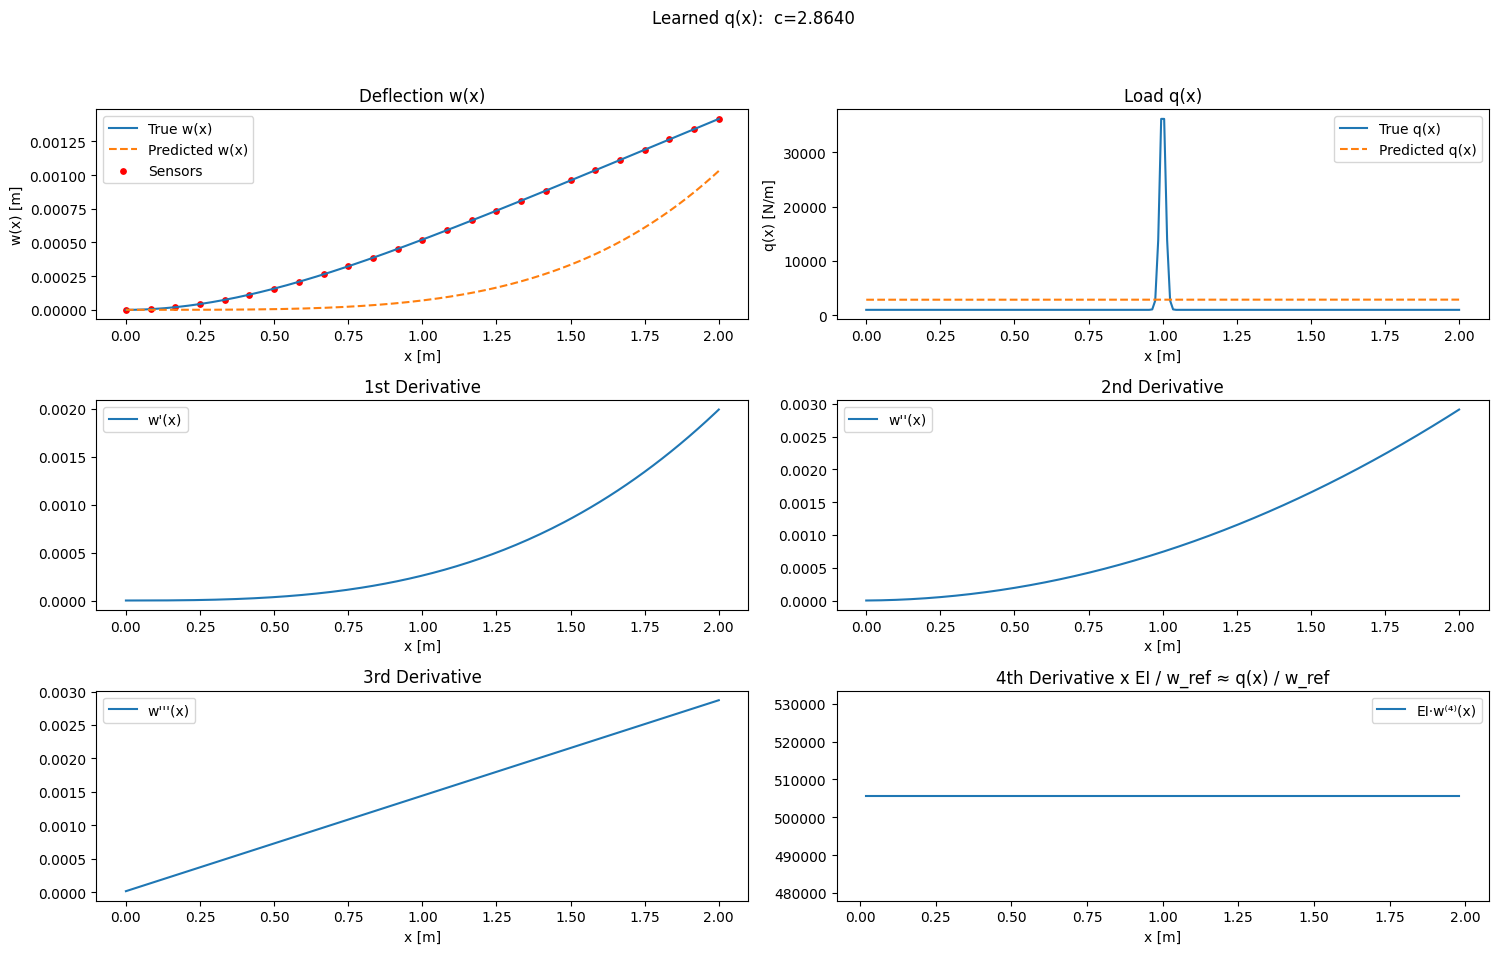

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.86395525932312>

In [272]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 2)

# Define plotting x and evaluate true values
x_plot = x_full  # Dimensional x values
#w_true = w_point_load(x_plot)  # True analytical deflection

plt.subplot(gs[0, 0])
plt.plot(x_plot, w_true, label="True w(x)")
plt.plot(x_plot, w_pred, '--', label="Predicted w(x)")
plt.scatter(x_sensors, w_sensors, color='red', label="Sensors", s=15)
plt.title("Deflection w(x)")
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()

plt.subplot(gs[0, 1])
plt.plot(x_plot, q_true, label="True q(x)")
plt.plot(x_plot, q_pred, '--', label="Predicted q(x)")
plt.title("Load q(x)")
plt.xlabel("x [m]")
plt.ylabel("q(x) [N/m]")
plt.legend()

plt.subplot(gs[1, 0])
plt.plot(x_plot, dw.numpy(), label="w'(x)")
plt.title("1st Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[1, 1])
plt.plot(x_plot, d2w.numpy(), label="w''(x)")
plt.title("2nd Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[2, 0])
plt.plot(x_plot, d3w.numpy(), label="w'''(x)")
plt.title("3rd Derivative")
plt.xlabel("x [m]")
plt.legend()

# Ensure w_ref is defined for correct scaling
w_ref = L**4 / EI

plt.subplot(gs[2, 1])
plt.plot(x_plot[2:-2], d4w[2:-2] * w_max / w_ref, label="EI·w⁽⁴⁾(x)")
#plt.plot(x_plot, q_pred , '--', label="Predicted q(x) / w_ref")
plt.title("4th Derivative x EI / w_ref ≈ q(x) / w_ref")
plt.xlabel("x [m]")
plt.legend()
plt.suptitle(f"Learned q(x):  c={q_dim:.4f}")

from sklearn.metrics import r2_score
r2_data = r2_score(w_true, w_pred)
print(f"R² score (PINN Model): {r2_data:.5f}")
#plt.suptitle(f"Learned q(x): a={a_dim:.4f}, b={b_dim:.4f}, c={c_dim:.4f}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# Compute R²


q_hat_norm

Text(0.5, 1.0, 'loading prediction over epochs')

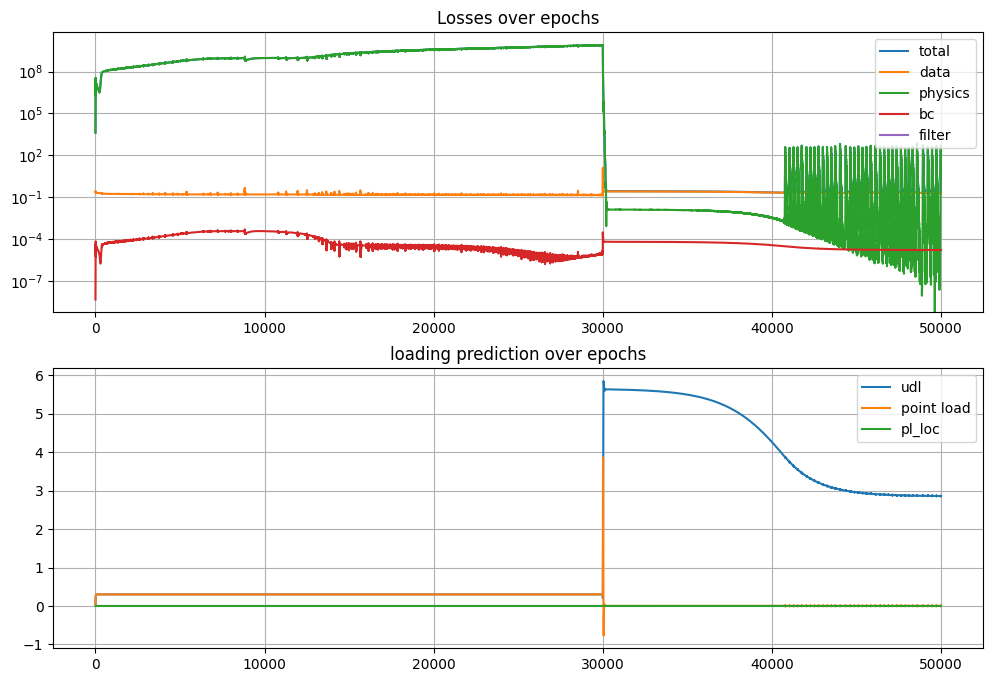

In [273]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(history['loss'], label = 'total')
plt.plot(history['data'], label = 'data')
plt.plot(history['phys'], label = 'physics')
plt.plot(history['bc'], label = 'bc')
plt.plot(history['filter'], label = 'filter')
plt.legend()
plt.grid(True)
plt.title("Losses over epochs")
plt.yscale('log')

plt.subplot(212)
plt.plot(history['q_hat_norm'], label = 'udl')
plt.plot(history['q_pl_norm'], label = 'point load')
plt.plot(history['pl_loc'], label = 'pl_loc')
plt.legend()
plt.grid(True)
plt.title("loading prediction over epochs")

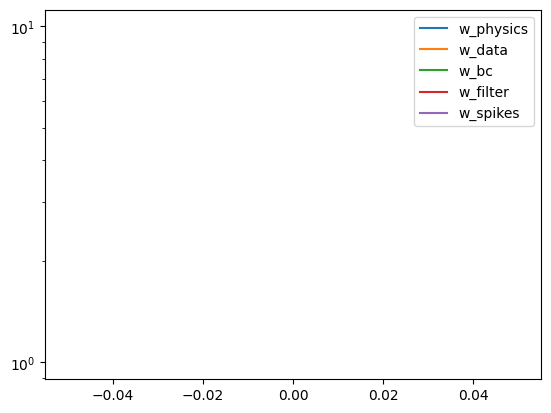

In [274]:
plt.plot(history_weights['w_phys'], label = 'w_physics')
plt.plot(history_weights['w_data'], label = 'w_data')
plt.plot(history_weights['w_bc'], label = 'w_bc')
plt.plot(history_weights['w_filter'], label = 'w_filter')
plt.plot(history_weights['w_spikes'], label = 'w_spikes')

plt.yscale('log')
plt.legend()